In [1]:
# Example Application of Hough Line Transform
# Michael Timbes
# Based off of: https://alyssaq.github.io/2014/understanding-hough-transform/

# Hough Transform (Lines)
> The Hough transform can be used after applying an edge filter to find lines and circles in an image. The idea behind this method is taking a set of points produced by the filter and treating them as if they were all lines in another space (Hough space). In the space of lines, the points of intersections represent a line in the original space(cartesian space). 
## How to Get Lines
> These intersections are accounted for by votes which are stored in an accumulator. The accumulator has a certain structure to maintain most of the information about the point. <br>
<b>Accumulator:</b><br>
[ $\rho$, $\theta$ ] = <b>Vote</b> <br>
> As the accumulator structure suggests, the Hough space is in terms of a radius length and position (given by theta). The more votes a certain radius and position has, the greater the likelyhood of a line being present. Once the votes have been accounted for, one may rebuild the lines to plot ontop of the image. The relationship between rho and the (X,Y) values are outlined below in the polar representation of the cartesian space.<br>
$$\rho = x\cos (\theta) + y\sin(\theta)$$ 
The votes are based on the specific (X,Y) points. So that when rho is found from above, the votes at that specific rho and theta are added up. <br>
## Finding Lines from the Accumulator
> So with the accumulator, the first value of importance are the votes at each rho and theta. If someone is looking for just one line, it may be sufficient to find the point of the highest votes and then use the theta and rho value to plot the line. <br>
<b>Equation to Rebuild Lines</b> <br>
$m = \frac{-\cos(\theta)}{\sin(\theta)},b = \frac{\rho}{\sin(\theta)}$ <br>
$y = mx + b$ <br>
The idea is to plot the strongest line using the rho and theta associated with that value along all of the x axis.

In [2]:
from PIL import Image as img # Used to import photos
from PIL import ImageFilter as imfil # Filters
import matplotlib.pyplot as plt # Show images
import numpy as np # Math Ops

In [3]:
def find_votes(ac, key):
    """
    INPUT: ac[rhos,thetas] - Where each [rho,theta] points to a vote and a key that is a threshold for
           ideal strength of lines (in terms of votes).
    
    OUT: mxvotes[n] - List of votes that meet or exceed threshold.
    """
    mx_rho = ac.shape[0]
    mx_theta = ac.shape[1]
    mx_votes = []
    for i in range(mx_rho):
        for j in range(mx_theta):
            if (ac[i,j] >= key):
                mx_votes.append((i,j))
    return np.asarray(mx_votes)

In [49]:
def gen_line(rho, theta, x, scale):
    #b = rho/(np.sin(theta))
    #m = (-np.cos(theta)/np.sin(theta))
    #y = m * x + b
    y = []
    #b = 0
    for i in range(len(rho)):
            # Finding B
        b = rho[i]/(np.sin(theta[i]))
            
            #Finding Slope
        m = (-np.cos(theta[i])/np.sin(theta[i]))
            
            # Finding Line @ M and B, Scale = .5 Max Rho Length
        y_val = np.rint(((m*(x[:])) + b) - scale)
        y.append(y_val)
                      
    return np.asarray(y)

In [55]:
def gen_linev2(rho, theta, x, scale):
    #b = rho/(np.sin(theta))
    #m = (-np.cos(theta)/np.sin(theta))
    #y = m * x + b
    b = rho/(np.sin(theta))
    #b = 0
    m = ((np.cos(theta)) /np.sin(theta))
    print(m)
    #m=1
    #for i in range(len(x)):
    y = np.rint((m*(rho*np.cos(theta)) + b) - scale)
    return np.asarray(y)

In [6]:
def hough_trans(im,res=1):
    """
    INPUT:
    ((bin) image 2D vector)
    
    OUPUT:
    ((float64) theta): Angle vals in radians for precision
    ((float64) rhosp): Radius of line segments
    ((int) accu): Accumulator for tracking voting
    """
    # Assign References
    width, height = im.shape
    print("Width, Height",width, height)
    
    # Max Line Segment Length
    max_lin = np.ceil(np.sqrt((width**2) + (height**2)))
    max_lin = max_lin.astype(np.uint64)
    print("Maximum Rho: ",2*max_lin)
    # Rho Space Vector
    rhosp = np.linspace(-max_lin, max_lin, max_lin * 2.0)
    
    # Theta Space Vector in Radians
    theta = np.deg2rad(np.arange(-90.0, 90.0, res))
    
    # Build Trig Funcs
    cos_arr = np.cos(theta)
    #cos_arr = cos_arr.astype(np.int64)
    sin_arr = np.sin(theta)
    #sin_arr = sin_arr.astype(np.int64)
    
    steps = len(theta)
    
    # Build Accumulator
    R = 2*max_lin
    R = R.astype(np.uint64) 
    accu = np.zeros((R, steps))
    
    # Index Edge Points
    [idx_y, idx_x] = np.nonzero(im)
    length_x = len(idx_x)
    print(len(idx_y),length_x)
    print(steps)
    # Voting Process 
    # Time Complexity in Terms of Operations: O(n^2)
    for i in range(length_x):
        x = idx_x[i]
        y = idx_y[i]
        for t in range(steps):
            rho = np.rint((x*cos_arr[t] + y*sin_arr[t]) + max_lin)
            rho = rho.astype(np.uint64)
            accu[rho, t] +=1
    return accu,theta,rhosp
        

(253, 300)


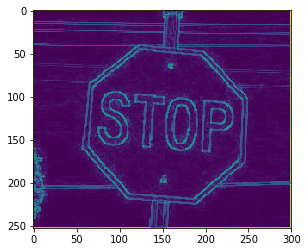

Width, Height 253 300
Maximum Rho:  786.0
68775 68775
23


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [7]:
stp_sign = img.open("stopsign.jpg", 'r')
stp_sign = stp_sign.convert("L")

# Smoothing Filter- add if there is a lot of noise.
#stp_sign = stp_sign.filter(imfil.GaussianBlur(2))

# Interesting that running a negative scale and then a positive scale filter and blending the two results 
# creates a very clear image of the edges for this stop sign. 

# Run Negative Scale Edge Filter
sobel_scale = .75
sobel_kernel_nX = stp_sign.filter(imfil.Kernel((3,3),[-1, 0, 1, -2, 0, 2, -1, 0, 1],-sobel_scale)) # X Direction
sobel_kernel_nY = stp_sign.filter(imfil.Kernel((3,3),[1, 2, 1, 0, 0, 0, -1, -2, -1],-sobel_scale)) # Y Direction

# Run Positive Scale Edge Filter
sobel_kernel_X = stp_sign.filter(imfil.Kernel((3,3),[-1, 0, 1, -2, 0, 2, -1, 0, 1],sobel_scale)) # X Direction
sobel_kernel_Y = stp_sign.filter(imfil.Kernel((3,3),[1, 2, 1, 0, 0, 0, -1, -2, -1],sobel_scale)) # Y Direction

# Negative Blending
neg_sign = img.blend(sobel_kernel_nX,sobel_kernel_nY,.5)
#neg_sign.show()

# Positive Blending
psv_sign = img.blend(sobel_kernel_X,sobel_kernel_Y,.5)
#psv_sign.show()

# Result of Negative and Positive
new_sign = img.blend(neg_sign,psv_sign,.5)
#new_sign.show()


# Cast to Numpy Array
stp_sign = np.array(new_sign)
print(stp_sign.shape)
plt.imshow(stp_sign)
plt.show()
# Generate Lines
ac, thet, rhos = hough_trans(stp_sign,8)

In [8]:
# Information on Structure
print(ac.shape)
print("Rhospace: ",ac.shape[0])
mx_rho = ac.shape[0]
print("Degrees: ",ac.shape[1])


(786, 23)
Rhospace:  786
Degrees:  23


In [9]:
# Pull Votes
mx_votes = find_votes(ac, 350)
print("Numer of Matches: ", len(mx_votes))

Numer of Matches:  36


In [10]:
# Example of Results
rho_k = mx_votes[30,0]
theta_k = mx_votes[30,1]

print(ac[rho_k,theta_k])

# Separate Rho and Theta into Vectors
RHO = mx_votes[:,0]
print("RHO VALUES: ", RHO)
THET = thet[mx_votes[:,1]]
THET = np.rad2deg(THET) # Converting Radians to Degrees
print("THETA VALUES(DEGREES): ", THET)

# Create an X vector from 0 to the X size of image
X_V = np.arange(0, stp_sign.shape[0], 1)
Y_V = np.arange(0, stp_sign.shape[1], 1)

356.0
RHO VALUES:  [343 350 357 359 364 366 373 387 389 389 390 391 392 393 394 394 395 396
 396 397 398 399 400 401 578 579 580 581 582 583 584 585 586 587 588 590]
THETA VALUES(DEGREES):  [-58. -58. -58. -58. -58. -58. -58. -58. -58. -50. -50. -50. -50. -50. -58.
 -50. -50. -58. -50. -50. -50. -50. -50. -50.  54.  54.  54.  54.  54.  54.
  54.  54.  54.  54.  54.  54.]


In [56]:
# Return Lines, Should be Same Length as the Number of Matches from mx_votes
Y = gen_line(RHO,THET,X_V, 2*mx_rho)
PTS = gen_linev2(RHO[11], THET[11], X_V, (mx_rho))
#PTS = gen_linev3(RHO,THET,.5*mx_rho)
print(PTS.shape)
#print(len(PTS))
print(PTS)
plt.plot(X_V,PTS)
plt.show()

3.67781445085
()
2092.0


ValueError: x and y must have same first dimension, but have shapes (253,) and (1,)

(36, 253)
[-1925. -1924. -1924. -1924. -1924. -1924. -1924. -1924. -1924. -1923.
 -1923. -1923. -1923. -1923. -1923. -1923. -1923. -1922. -1922. -1922.
 -1922. -1922. -1922. -1922. -1922. -1922. -1921. -1921. -1921. -1921.
 -1921. -1921. -1921. -1921. -1920. -1920. -1920. -1920. -1920. -1920.
 -1920. -1920. -1919. -1919. -1919. -1919. -1919. -1919. -1919. -1919.
 -1919. -1918. -1918. -1918. -1918. -1918. -1918. -1918. -1918. -1917.
 -1917. -1917. -1917. -1917. -1917. -1917. -1917. -1916. -1916. -1916.
 -1916. -1916. -1916. -1916. -1916. -1916. -1915. -1915. -1915. -1915.
 -1915. -1915. -1915. -1915. -1914. -1914. -1914. -1914. -1914. -1914.
 -1914. -1914. -1913. -1913. -1913. -1913. -1913. -1913. -1913. -1913.
 -1913. -1912. -1912. -1912. -1912. -1912. -1912. -1912. -1912. -1911.
 -1911. -1911. -1911. -1911. -1911. -1911. -1911. -1910. -1910. -1910.
 -1910. -1910. -1910. -1910. -1910. -1910. -1909. -1909. -1909. -1909.
 -1909. -1909. -1909. -1909. -1908. -1908. -1908. -1908. -1908. -19

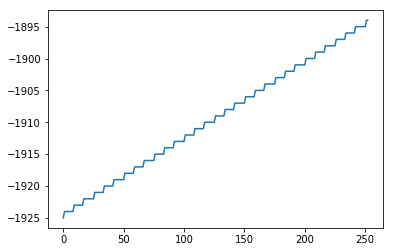

In [53]:
print(Y.shape)
print(Y[1,:])
#print(Y_V[1,:])
plt.plot(X_V,Y[1,:])
plt.show()